# Southern Hemisphere:
## Compile average area, age, count, etc of icebergs within 50 or 100 km of each grid point

In [1]:
#!conda activate gfdl
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xesmf
import pandas as pd
import netCDF4 as nc
import gfdlvitals
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import copy
from matplotlib.figure import figaspect
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
_ = xr.set_options(display_style='text')

In [2]:
def reindex_byu_nic(din,columnsin):
    din2=din.to_numpy()
    din2=din2.copy()
    dout = pd.DataFrame(din2, columns = columnsin)
    return dout

In [3]:
#False if processing already done (trajectories already assigned to mesh and saved)
firstrun=True

rb_small is a dataset of bergs that never exceeded an nic_size of 1000 km^2. Bergs with nic_size == 0 are dropped as well.

In [4]:
#all bergs are eliminated that have area>1000 km^2
if firstrun:
    drop_all_big_and_child=False #if true, all child bergs of any parent berg that was ever >1000 km^2 are also eliminated
    removeuk=False #True
    maxsize=10000000
    minsize=-1
    #var='size'
    var='nic_size'
    rb_small = pd.read_csv('/net/aeh/data/byu_nic_bergs_sizes.csv',sep=' ')
    rb_small=rb_small.drop(columns=["mask","cnt"])
    
    rb_small = rb_small[rb_small[var] >= minsize]
    rb_small = rb_small[rb_small[var]<=maxsize]

    rb_small.shape
    rb2=rb_small.to_numpy()
    rb2=rb2.copy()
    columnsin=['date','lat','lon','size','nic_size','nic_size_1','nic_size_2','berg_name']
    rb_small = pd.DataFrame(rb2, columns = columnsin)

    big_bergs=[]
    big_bergs2=[]

    if drop_all_big_and_child:
        for cnt,size in enumerate(rb_small.nic_size):
            if size>maxsize:
                big_bergs.append(rb_small.at[cnt,'berg_name'])


        big_bergs=list(set(big_bergs)) 

        rb_small = rb_small[~rb_small['berg_name'].isin(big_bergs)]
        rb_small = rb_small[rb_small[var]>minsize]

        for bn in rb_small.berg_name:
            for bn2 in big_bergs:
                if bn2 in bn:
                    big_bergs2.append(bn)

        big_bergs2=list(set(big_bergs2)) 
        rb_small = rb_small[~rb_small['berg_name'].isin(big_bergs2)]
    else:
        rb_small = rb_small[rb_small[var]<=maxsize]
        rb_small = rb_small[rb_small[var]>=minsize]

    if removeuk:
        big_bergs2=[]
        for bn in rb_small.berg_name:
            if 'uk' in bn:
                big_bergs2.append(bn)
        rb_small = rb_small[~rb_small['berg_name'].isin(big_bergs2)]
    rb_small = reindex_byu_nic(rb_small,columnsin)

In [7]:
dir='/archive/aeh/FMS2019.01.03_mom6_2019.08.08'
#only iceberg trajectories from 1990 through 2017 are used here:
trajectories='gfdl.ncrc3-intel18-prod/history/iceberg_trajectories_1990_2017.nc'
annualdir='gfdl.ncrc3-intel18-prod/pp/icebergs_monthly/av/annual_5yr/'

rhoi=850; m2_to_km2 = 1.e-6
decode_timedelta=False
sort_traj=False
cutoff_year=0#1990

#do not load these trajectory variables:
drop=['start_mass','mass_of_bits','mass_of_fl_bits','mass_of_fl_bergy_bits','fl_k','mass_scaling']
run1='e100_s.5_r/'

todrop=['time','mass_class','area','melt','melt_buoy','melt_eros','melt_conv','bergy_src','bergy_melt','bergy_mass','virtual_area','mass','calving_hflx_in','unused_calving','accum_calving','real_calving','stored_ice','calving','fl_bits_src','fl_bits_melt','fl_bits_mass','melt_buoy_fl','melt_eros_fl','melt_conv_fl','melt_by_class','fl_parent_melt','fl_child_melt','fl_bergy_bits_mass','cn','sst','uo','vo','ui','vi','ua','va','time_bnds','average_T1','average_T2','average_DT']
r1_m = xr.open_dataset(f'{dir}/{run1}/{annualdir}/icebergs_monthly.1958-1962.ann.nc',drop_variables=todrop)

In [7]:
#FILES
if firstrun:
    dir='/archive/aeh/FMS2019.01.03_mom6_2019.08.08'
    trajectories='gfdl.ncrc3-intel18-prod/history/iceberg_trajectories_1990_2017.nc'
    annualdir='gfdl.ncrc3-intel18-prod/pp/icebergs_monthly/av/annual_5yr/'

    rhoi=850; m2_to_km2 = 1.e-6
    decode_timedelta=False
    sort_traj=False
    cutoff_year=0#1990

    #do not load these trajectory variables:
    drop=['start_mass','mass_of_bits','mass_of_fl_bits','mass_of_fl_bergy_bits','fl_k','mass_scaling']
    run1='e100_s.5_r/'

    todrop=['time','mass_class','area','melt','melt_buoy','melt_eros','melt_conv','bergy_src','bergy_melt','bergy_mass','virtual_area','mass','calving_hflx_in','unused_calving','accum_calving','real_calving','stored_ice','calving','fl_bits_src','fl_bits_melt','fl_bits_mass','melt_buoy_fl','melt_eros_fl','melt_conv_fl','melt_by_class','fl_parent_melt','fl_child_melt','fl_bergy_bits_mass','cn','sst','uo','vo','ui','vi','ua','va','time_bnds','average_T1','average_T2','average_DT']
    r1_m = xr.open_dataset(f'{dir}/{run1}/{annualdir}/icebergs_monthly.1958-1962.ann.nc',drop_variables=todrop)

    r1 = xr.open_dataset(f'{dir}/{run1}/{trajectories}',decode_timedelta=decode_timedelta,drop_variables=drop)

    run2='e100_s.5_nb_r/'
    r2 = xr.open_dataset(f'{dir}/{run2}/{trajectories}',decode_timedelta=decode_timedelta,drop_variables=drop)

    run3='e10_s.25_r/'
    r3 = xr.open_dataset(f'{dir}/{run3}/{trajectories}',decode_timedelta=decode_timedelta,drop_variables=drop)

    run4='e10_s.1_r/'
    r4 = xr.open_dataset(f'{dir}/{run4}/{trajectories}',decode_timedelta=decode_timedelta,drop_variables=drop)

    run5='no_footloose_r/'
    r5 = xr.open_dataset(f'{dir}/{run5}/{trajectories}',decode_timedelta=decode_timedelta,drop_variables=drop)

    run6='gladstone_bigg_r/'
    r6 = xr.open_dataset(f'{dir}/{run6}/{trajectories}',decode_timedelta=decode_timedelta)#,drop_variables=drop)

    if cutoff_year>0:
        r1=r1.where(r1['year'] >= cutoff_year, drop=True)
        r2=r2.where(r2['year'] >= cutoff_year, drop=True)
        r3=r3.where(r3['year'] >= cutoff_year, drop=True)
        r4=r4.where(r1['year'] >= cutoff_year, drop=True)
        r5=r5.where(r2['year'] >= cutoff_year, drop=True)
        r6=r6.where(r3['year'] >= cutoff_year, drop=True)

    r1['id'] = r1['id_cnt']*2**32+r1['id_ij']
    r2['id'] = r2['id_cnt']*2**32+r2['id_ij']
    r3['id'] = r3['id_cnt']*2**32+r3['id_ij']
    r4['id'] = r4['id_cnt']*2**32+r4['id_ij']
    r5['id'] = r5['id_cnt']*2**32+r5['id_ij']
    r6['id'] = r6['id_cnt']*2**32+r6['id_ij']

    drop=['id_cnt','id_ij']
    r1=r1.drop(drop)
    r2=r2.drop(drop)
    r3=r3.drop(drop)    
    r4=r4.drop(drop)
    r5=r5.drop(drop)
    r6=r6.drop(drop)    

    r1['area'] = m2_to_km2*r1['mass']/(rhoi*r1['thickness'])
    r2['area'] = m2_to_km2*r2['mass']/(rhoi*r2['thickness'])
    r3['area'] = m2_to_km2*r3['mass']/(rhoi*r3['thickness'])
    r4['area'] = m2_to_km2*r4['mass']/(rhoi*r4['thickness'])
    r5['area'] = m2_to_km2*r5['mass']/(rhoi*r5['thickness'])
    r6['area'] = m2_to_km2*r6['mass']/(rhoi*r6['thickness'])

    r1=r1.sortby(r1['area'])
    r2=r2.sortby(r2['area'])
    r3=r3.sortby(r3['area'])
    r4=r4.sortby(r4['area'])
    r5=r5.sortby(r5['area'])
    r6=r6.sortby(r6['area'])

# Get number of unique and total bergs, and average berg area and age, within 100 km^2 of a grid node¶

work in slices of longitude, adjusting so that lat/lon for both bergs and mesh is centered at some point, and adjusted so that there is no wrap-around.

# Assign berg ages

In [8]:
#centers the range of longitude on midlon
def center_lon(ds,midlon,is_xr):
    k=1
    minlon=midlon-180
    maxlon=midlon+180
    while (k == 1):
        k=0
        if is_xr:
            #xarray
            if (np.any(ds['lon']>maxlon)):
                ds['lon']=xr.where(ds['lon']>maxlon,ds['lon']-360,ds['lon']); k=1
            if (np.any(ds['lon']<minlon)):
                ds['lon']=xr.where(ds['lon']<minlon,ds['lon']+360,ds['lon']); k=1
        else:
            #pandas
            if (np.any(ds['lon']>maxlon)):
                ds.lon=ds.lon.mask(ds.lon>maxlon,ds.lon-360); k=1
            if (np.any(ds['lon']<minlon)):
                ds.lon=ds.lon.mask(ds.lon<minlon,ds.lon+360); k=1
    return ds

def redo_modeled_array(r1):
    print('redo_modeled_array...')
    r1=r1.where(r1['lat']<=0,drop=True)
    r1=r1.where(r1['area']>=5,drop=True)
    r1['time']=r1['year']-1990+r1['day']/370.
    bergs=list(set(r1['id'].values.astype(int))); bergs=np.sort(np.array(bergs))
    r1b=r1.drop(['year','day']); r1b=r1b.sortby(['id','time']); r1b['age']=r1b['time'].copy()*0
    r1bidvals=r1b.id.values; leng=len(r1bidvals); f_index=np.zeros(len(bergs)); cid=-1; k=0
    for i,val in enumerate(r1bidvals):
        if cid!=val:
            cid=val; f_index[k]=i; k+=1
    f_index=f_index.astype(int); l_index=f_index[1:len(f_index)]; l_index=np.append(l_index,leng)
    for i in range(len(f_index)):
        r1b['age'][f_index[i]:l_index[i]]=r1b['time'][f_index[i]]
    r1b['age']=r1b['time']-r1b['age']
    print('done')
    return r1b

def redo_rb_array(rb):
    print('redo_rb_array...')
    rb['year']=np.around(rb.date.values.astype('float')/1000.)
    rb['day']=rb['date']-np.around(rb.date.values.astype('float')/1000.)*1000
    rb['time']=rb['year']-1990+rb['day']/366.
    bergs=list(set(rb['id'].values)); bergs=np.sort(bergs)
    rbb=rb.drop(columns=['year','day']); rbb=rbb.sort_values(by=['id','time']); rbb['age']=rbb['time'].copy()*0
    rbbidvals=rbb.id.values; leng=len(rbbidvals); f_index=np.zeros(len(bergs)); cid=-1; k=0
    for i,val in enumerate(rbbidvals):
        if cid!=val:
            cid=val; f_index[k]=i; k+=1
    f_index=f_index.astype(int); l_index=f_index[1:len(f_index)]; l_index=np.append(l_index,leng)
    for i in range(len(f_index)):
        rbb['age'].iloc[f_index[i]:l_index[i]]=rbb['time'][f_index[i]]
    rbb['age']=rbb['time']-rbb['age']
    print('done')
    return rbb

# Get number of unique and total bergs, and average berg area and age, within 100 km^2 of a grid node

-work in slices of longitude, adjusting so that lat/lon for both bergs and mesh is centered at some point, and adjusted so that there is no wrap-around.
-for each slice, 

In [9]:
def haversine_dist(lon1,lat1,lon2,lat2):
    R=6360000

    p1 = lat1 * np.pi/180
    p2 = lat2 * np.pi/180
    dp = (lat2-lat1) * np.pi/180
    dm = (lon2-lon1) * np.pi/180

    a = np.sin(0.5*dp)**2 + np.cos(p1) * np.cos(p2) * np.sin(0.5*dm)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    d = R * c
    return d

def fl_traj_to_mesh(r1_m,r1,kernel):
    print('starting fl_traj_to_mesh...')
    mesh_s=r1_m.copy()
    mesh_s=mesh_s.where(mesh_s['lat']<=-30,drop=True)
    
    #constants
    target_dist_km=kernel
    Rearth=6360000.; mult=(np.pi/180.); mult2=(mult*Rearth)**2
    mult=0.5*mult
    
    #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
    #target_dist=(target_dist_km*1e3)**2
    #most accurage way (haversine dist):
    target_dist=target_dist_km*1e3

    modeled=redo_modeled_array(r1)
    modeled_ub_len=len(set(modeled.id.values))
    modeled_len=len(modeled.id)

    mesh_s['u_bcount_modeled']=mesh_s['lon'].copy()
    mesh_s['u_bcount_modeled'][:,:]=0
    mesh_s['u_barea_modeled']=mesh_s['u_bcount_modeled'].copy()
    mesh_s['u_barea_modeled_over100kms']=mesh_s['u_bcount_modeled'].copy()
    mesh_s['u_barea_modeled_over200kms']=mesh_s['u_bcount_modeled'].copy()
    mesh_s['u_bage_modeled']=mesh_s['u_barea_modeled'].copy()
    modeled['dist']=modeled['area'].copy()*0
    print('modeled: total number of unique bergs',modeled_ub_len)
    print('modeled: total number of berg samples',modeled_len)

    #onehundrednm=100*1.852*1.852
    onehundredkm=100

    minlat=min(mesh_s['lat'].min().values,modeled['lat'].min().values)
    
    latm=minlat-0.01 #a small buffer
    lonm=0; lonm2=1; latm2=latm

    #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
    #min_gx=np.sqrt(mult2*(((lonm-lonm2)*np.cos((latm+latm2)*mult))**2+(latm-latm2)**2))/1000
    #most accurate way (haversine):
    min_gx=haversine_dist(lonm,latm,lonm2,latm2)/1000
    
    p_lon_buffer=target_dist_km/min_gx #this buffer is used to extend the sector of particle longitude in the below code

    min_gy=np.sqrt(mult2)/1000
    p_lat_buffer=target_dist_km/min_gy

    #min,mid,and max lons for grid and particle arrays, for splitting into 10 loops
    minlon_g=np.linspace(0,360,11)[0:-1]; maxlon_g=minlon_g+36.0 #for grid
    midlon=minlon_g+18.0 #for grid and particles
    minlon_p=minlon_g-p_lon_buffer
    maxlon_p=maxlon_g+p_lon_buffer #for particles

    print('starting iters...')
    #now add area and other stuff
    start=time.time()
    for iter in range(len(midlon)):
        curtime=time.time()
        print('minlon',minlon_g[iter],'midlon',midlon[iter],'maxlon',maxlon_g[iter])
        print('iter',iter+1,'of',len(midlon),'Time',curtime-start)
        #center longitude on midlon and extract smaller arrays
        mesh_s=center_lon(mesh_s,midlon[iter],is_xr=True)
        modeled=center_lon(modeled,midlon[iter],is_xr=True)
        modeled1=modeled.where((modeled['lon']>=minlon_p[iter]) & (modeled['lon']<=maxlon_p[iter]),drop=True)

        for i in range(len(mesh_s['xT'])):
            lonm=mesh_s['lon'][:,i].max().values
            if (lonm<=minlon_g[iter] or lonm>maxlon_g[iter] or np.isnan(lonm)):
                continue       
            for j in range(len(mesh_s['yT'])):

                latm=mesh_s['lat'][j,i].values
                if np.isnan(latm):
                    continue

                maxlat=latm+p_lat_buffer; minlat=latm-p_lat_buffer

                modeled2=modeled1.where((modeled1['lat']<=maxlat) & (modeled1['lat']>=minlat),drop=True)
                
                #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
                #modeled2['dist']=mult2*(((lonm-modeled2['lon'])*np.cos(mult*(latm+modeled2['lat'])))**2+(latm-modeled2['lat'])**2)
                #most accurate way (haversine):
                modeled2['dist']=haversine_dist(lonm,latm,modeled2['lon'],modeled2['lat'])
                
                modeled2=modeled2.where(modeled2['dist']<target_dist,drop=True)                  
                
                bset2=set(modeled2['id'].values.astype(int))
                mesh_s['u_bcount_modeled'][j,i]=len(bset2)

                mean_area=0; mean_area2=0; k2=0; mean_area3=0; k3=0
                for theid in bset2:
                    mesh_s['u_bage_modeled'][j,i]=mesh_s['u_bage_modeled'][j,i]+modeled2['age'][(modeled2['id']==theid)].mean()
                    mean_area=mean_area+modeled2['area'][(modeled2['id']==theid)].mean()
                    matemp=modeled2['area'][(modeled2['id']==theid) & (modeled2['area']>=onehundredkm)].mean()
                    if ~np.isnan(matemp):
                        mean_area2=mean_area2+matemp; k2=k2+1
                    matemp2=modeled2['area'][(modeled2['id']==theid) & (modeled2['area']>=200)].mean()
                    if ~np.isnan(matemp2):
                        mean_area3=mean_area3+matemp2; k3=k3+1
                        
                if (mesh_s['u_bcount_modeled'][j,i]>0):
                    mesh_s['u_barea_modeled'][j,i]=mean_area/mesh_s['u_bcount_modeled'][j,i]
                    if k2>0:
                        mesh_s['u_barea_modeled_over100kms'][j,i]=mean_area2/k2
                    else:
                        mesh_s['u_barea_modeled_over100kms'][j,i]=0
                    if k3>0:
                        mesh_s['u_barea_modeled_over200kms'][j,i]=mean_area3/k3
                    else:
                        mesh_s['u_barea_modeled_over200kms'][j,i]=0
                    mesh_s['u_bage_modeled'][j,i]=mesh_s['u_bage_modeled'][j,i]/mesh_s['u_bcount_modeled'][j,i]

    mesh_s['u_bcount_modeled']=mesh_s['u_bcount_modeled']/modeled_ub_len
    mesh_s['u_bcount_modeled']=mesh_s['u_bcount_modeled'].where(mesh_s['lon']>-10000)
    r1_m['u_bcount_modeled']=r1_m['mask']
    r1_m['u_bcount_modeled']=mesh_s['u_bcount_modeled'].where(mesh_s['lat']<=-30)
    r1_m['u_bcount_modeled']=xr.where(r1_m['lat']<=-30.0,r1_m['u_bcount_modeled'],r1_m['mask']-1)
    r1_m['u_bcount_modeled']=r1_m['u_bcount_modeled'].where(r1_m['mask']>0)
    r1_m['u_barea_modeled']=r1_m['mask']
    r1_m['u_barea_modeled']=mesh_s['u_barea_modeled'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_modeled']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_modeled'],r1_m['mask']-1)
    r1_m['u_barea_modeled']=r1_m['u_barea_modeled'].where(r1_m['mask']>0)
    
    r1_m['u_barea_modeled_over100kms']=r1_m['mask']
    r1_m['u_barea_modeled_over100kms']=mesh_s['u_barea_modeled_over100kms'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_modeled_over100kms']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_modeled_over100kms'],r1_m['mask']-1)
    r1_m['u_barea_modeled_over100kms']=r1_m['u_barea_modeled_over100kms'].where(r1_m['mask']>0)
    
    r1_m['u_barea_modeled_over200kms']=r1_m['mask']
    r1_m['u_barea_modeled_over200kms']=mesh_s['u_barea_modeled_over200kms'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_modeled_over200kms']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_modeled_over200kms'],r1_m['mask']-1)
    r1_m['u_barea_modeled_over200kms']=r1_m['u_barea_modeled_over200kms'].where(r1_m['mask']>0)
    
    r1_m['u_bage_modeled']=r1_m['mask']
    r1_m['u_bage_modeled']=mesh_s['u_bage_modeled'].where(mesh_s['lat']<=-30)
    r1_m['u_bage_modeled']=xr.where(r1_m['lat']<=-30.0,r1_m['u_bage_modeled'],r1_m['mask']-1)
    r1_m['u_bage_modeled']=r1_m['u_bage_modeled'].where(r1_m['mask']>0)

    return r1_m

In [10]:
#for nic bergs only
def fl_traj_to_mesh_rbonly(r1_m,rb_small,kernel):
    print('starting rb_traj_to_mesh...')
    mesh_s=r1_m.copy()
    mesh_s=mesh_s.where(mesh_s['lat']<=-30,drop=True)

    #make a copy of rb_small
    import pandas as pd
    columnsin=['date','lat','lon','size','nic_size','nic_size_1','nic_size_2','id']
    rb=rb_small.copy(); rb = rb[rb['date'] >= 1990000]; rb = rb[rb['date'] < 2018000]
    rb=rb.dropna(); rb=rb.to_numpy(); rb = pd.DataFrame(rb, columns = columnsin)
    #rb = rb[rb['nic_size'] > 0]
    rb=rb.set_index(np.arange(len(rb)))
    rb['nic_size']=rb['nic_size'].replace(0,np.NaN)
    rb['size']=rb['size'].replace(0,np.NaN)

    #constants
    target_dist_km=kernel
    Rearth=6360000.; mult=(np.pi/180.); mult2=(mult*Rearth)**2
    mult=0.5*mult
    
    #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
    #target_dist=(target_dist_km*1e3)**2
    #most accurate way (haversine dist):
    target_dist=target_dist_km*1e3

    rbb=redo_rb_array(rb)

    #how many unique bergs for rb
    #and how many total samples

    rb_ub_len=len(set(rbb.id.values))
    rb_len=len(rbb)

    mesh_s['u_bcount_nic']=mesh_s['lon'].copy()
    mesh_s['u_bcount_nic'][:,:]=0
    mesh_s['u_barea_nic']=mesh_s['u_bcount_nic'].copy()
    mesh_s['u_barea_nic_small']=mesh_s['u_bcount_nic'].copy()
    mesh_s['u_barea_nic_small_over100kms']=mesh_s['u_bcount_nic'].copy()
    mesh_s['u_barea_nic_small_over200kms']=mesh_s['u_bcount_nic'].copy()
    mesh_s['u_bage_nic']=mesh_s['u_bcount_nic'].copy()
    mesh_s['u_bage_nic_parents_only']=mesh_s['u_bcount_nic'].copy()
    rbb['dist']=rbb['nic_size'].copy()*0
    print('rb: total number of unique bergs',rb_ub_len)
    print('rb: total number of berg samples',rb_len)

    #onehundrednm=100*1.852*1.852
    onehundredkm=100
    
    minlat=rb['lat'].values.min()

    latm=minlat-0.01 #a small buffer
    lonm=0; lonm2=1; latm2=latm
    
    #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
    #min_gx=np.sqrt(mult2*(((lonm-lonm2)*np.cos((latm+latm2)*mult))**2+(latm-latm2)**2))/1000
    #most accurate way (haversine):
    min_gx=haversine_dist(lonm,latm,lonm2,latm2)/1000
    
    p_lon_buffer=target_dist_km/min_gx #this buffer is used to extend the sector of particle longitude in the below code

    min_gy=np.sqrt(mult2)/1000
    p_lat_buffer=target_dist_km/min_gy

    #min,mid,and max lons for grid and particle arrays, for splitting into 10 loops
    minlon_g=np.linspace(0,360,11)[0:-1]; maxlon_g=minlon_g+36.0 #for grid
    midlon=minlon_g+18.0 #for grid and particles
    minlon_p=minlon_g-p_lon_buffer
    maxlon_p=maxlon_g+p_lon_buffer #for particles

    print('starting iters...')
    #now add area and other stuff
    start=time.time()
    for iter in range(len(midlon)):
        curtime=time.time()
        print('minlon',minlon_g[iter],'midlon',midlon[iter],'maxlon',maxlon_g[iter])
        print('iter',iter+1,'of',len(midlon),'Time',curtime-start)
        #center longitude on midlon and extract smaller arrays
        mesh_s=center_lon(mesh_s,midlon[iter],is_xr=True)
        rbb=center_lon(rbb,midlon[iter],is_xr=False)
        rb1=rbb[(rbb['lon']>=minlon_p[iter]) & (rbb['lon']<=maxlon_p[iter])].copy()

        for i in range(len(mesh_s['xT'])):
            lonm=mesh_s['lon'][:,i].max().values
            if (lonm<=minlon_g[iter] or lonm>maxlon_g[iter] or np.isnan(lonm)):
                continue       
            for j in range(len(mesh_s['yT'])):

                latm=mesh_s['lat'][j,i].values
                if np.isnan(latm):
                    continue

                maxlat=latm+p_lat_buffer; minlat=latm-p_lat_buffer

                rb2=rb1.iloc[((rb1['lat']<=maxlat) & (rb1['lat']>=minlat)).values].copy()
                
                #faster way (not using haversine dist). Gives indistinguishable result as haversine approach:
                #rb2.loc[:,'dist']=mult2*(((lonm-rb2['lon'])*np.cos(mult*(latm+rb2['lat'].astype(float))))**2+(latm-rb2['lat'])**2)
                #most accurate way (haversine):
                rb2.loc[:,'dist']=haversine_dist(lonm,latm,rb2['lon'].astype(float),rb2['lat'].astype(float))
                
                rb2=rb2.loc[rb2['dist']<target_dist]
                bset=set(rb2['id'])
                mesh_s['u_bcount_nic'][j,i]=len(bset)

                k=0; temp_area=0; mean_area=0
                k_small=0; temp_area_small=0; mean_area_small=0
                k_small2=0; temp_area_small2=0; mean_area_small2=0
                k_small3=0; temp_area_small3=0; mean_area_small3=0
                for theid in bset:
                    mesh_s['u_bage_nic'][j,i]=mesh_s['u_bage_nic'][j,i]+rb2['age'][(rb2['id']==theid)].mean()
                    if (theid[-1].isalpha()==False):
                        mesh_s['u_bage_nic_parents_only'][j,i]=mesh_s['u_bage_nic_parents_only'][j,i]+rb2['age'][(rb2['id']==theid)].mean()
                    temp_area=rb2['nic_size'][(rb2['id']==theid)].mean()
                    temp_area_small=rb2['nic_size'][(rb2['id']==theid) & (rb2['nic_size']<=1000)].mean()
                    temp_area_small2=rb2['nic_size'][(rb2['id']==theid) & (rb2['nic_size']<=1000) & (rb2['nic_size']>=onehundredkm)].mean()
                    temp_area_small3=rb2['nic_size'][(rb2['id']==theid) & (rb2['nic_size']<=1000) & (rb2['nic_size']>=200)].mean()
                    
                    if ~np.isnan(temp_area):
                        mean_area=mean_area+temp_area; k=k+1
                    if ~np.isnan(temp_area_small):
                        mean_area_small=mean_area_small+temp_area_small; k_small=k_small+1  
                    if ~np.isnan(temp_area_small2):
                        mean_area_small2=mean_area_small2+temp_area_small2; k_small2=k_small2+1
                    if ~np.isnan(temp_area_small3):
                        mean_area_small3=mean_area_small3+temp_area_small3; k_small3=k_small3+1  
                if (k>0 and mean_area>0):
                    mesh_s['u_barea_nic'][j,i]=mean_area/k
                else:
                    mesh_s['u_barea_nic'][j,i]=0
                if (k_small>0 and mean_area_small>0):
                    mesh_s['u_barea_nic_small'][j,i]=mean_area_small/k_small
                else:
                    mesh_s['u_barea_nic_small'][j,i]=0       
                if (k_small2>0 and mean_area_small2>0):
                    mesh_s['u_barea_nic_small_over100kms'][j,i]=mean_area_small2/k_small2
                else:
                    mesh_s['u_barea_nic_small_over100kms'][j,i]=0   
                    
                if (k_small3>0 and mean_area_small3>0):
                    mesh_s['u_barea_nic_small_over200kms'][j,i]=mean_area_small3/k_small3
                else:
                    mesh_s['u_barea_nic_small_over200kms'][j,i]=0 

                if (mesh_s['u_bcount_nic'][j,i]>0):
                    mesh_s['u_bage_nic'][j,i]=mesh_s['u_bage_nic'][j,i]/mesh_s['u_bcount_nic'][j,i]
                    mesh_s['u_bage_nic_parents_only'][j,i]=mesh_s['u_bage_nic_parents_only'][j,i]/mesh_s['u_bcount_nic'][j,i]

    mesh_s['u_bcount_nic']=mesh_s['u_bcount_nic']/rb_ub_len
    r1_m['u_bcount_nic']=r1_m['mask']
    r1_m['u_bcount_nic']=mesh_s['u_bcount_nic'].where(mesh_s['lat']<=-30)
    r1_m['u_bcount_nic']=xr.where(r1_m['lat']<=-30.0,r1_m['u_bcount_nic'],r1_m['mask']-1)
    r1_m['u_bcount_nic']=r1_m['u_bcount_nic'].where(r1_m['mask']>0)
    r1_m['u_barea_nic']=r1_m['mask']
    r1_m['u_barea_nic']=mesh_s['u_barea_nic'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_nic']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_nic'],r1_m['mask']-1)
    r1_m['u_barea_nic']=r1_m['u_barea_nic'].where(r1_m['mask']>0)
    r1_m['u_bage_nic']=r1_m['mask']
    r1_m['u_bage_nic']=mesh_s['u_bage_nic'].where(mesh_s['lat']<=-30)
    r1_m['u_bage_nic']=xr.where(r1_m['lat']<=-30.0,r1_m['u_bage_nic'],r1_m['mask']-1)
    r1_m['u_bage_nic']=r1_m['u_bage_nic'].where(r1_m['mask']>0)
    r1_m['u_bage_nic_parents_only']=r1_m['mask']
    r1_m['u_bage_nic_parents_only']=mesh_s['u_bage_nic_parents_only'].where(mesh_s['lat']<=-30)
    r1_m['u_bage_nic_parents_only']=xr.where(r1_m['lat']<=-30.0,r1_m['u_bage_nic_parents_only'],r1_m['mask']-1)
    r1_m['u_bage_nic_parents_only']=r1_m['u_bage_nic_parents_only'].where(r1_m['mask']>0)
    r1_m['u_barea_nic_small']=r1_m['mask']
    r1_m['u_barea_nic_small']=mesh_s['u_barea_nic_small'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_nic_small']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_nic_small'],r1_m['mask']-1)
    r1_m['u_barea_nic_small']=r1_m['u_barea_nic_small'].where(r1_m['mask']>0)
    r1_m['u_barea_nic_small_over100kms']=r1_m['mask']
    r1_m['u_barea_nic_small_over100kms']=mesh_s['u_barea_nic_small_over100kms'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_nic_small_over100kms']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_nic_small_over100kms'],r1_m['mask']-1)
    r1_m['u_barea_nic_small_over100kms']=r1_m['u_barea_nic_small_over100kms'].where(r1_m['mask']>0)
    r1_m['u_barea_nic_small_over200kms']=r1_m['mask']
    r1_m['u_barea_nic_small_over200kms']=mesh_s['u_barea_nic_small_over200kms'].where(mesh_s['lat']<=-30)
    r1_m['u_barea_nic_small_over200kms']=xr.where(r1_m['lat']<=-30.0,r1_m['u_barea_nic_small_over200kms'],r1_m['mask']-1)
    r1_m['u_barea_nic_small_over200kms']=r1_m['u_barea_nic_small_over200kms'].where(r1_m['mask']>0)
    
    
    r1_m['u_bcount_nic']=r1_m['u_bcount_nic'].fillna(0)
    r1_m['u_barea_nic']=r1_m['u_barea_nic'].fillna(0)
    r1_m['u_bage_nic']=r1_m['u_bage_nic'].fillna(0)
    r1_m['u_bage_nic_parents_only']=r1_m['u_bage_nic_parents_only'].fillna(0)
    r1_m['u_barea_nic_small']=r1_m['u_barea_nic_small'].fillna(0)
    r1_m['u_barea_nic_small_over100kms']=r1_m['u_barea_nic_small_over100kms'].fillna(0)
    r1_m['u_barea_nic_small_over200kms']=r1_m['u_barea_nic_small_over200kms'].fillna(0)
    r1_m=r1_m.where(r1_m['mask']==1)
    return r1_m

In [11]:
kernel=100 #km

In [12]:
firstrun=False
if firstrun:

    ms=r1_m.copy()
    
    if kernel==50:
        kernelstring="_50km"
    else:
        kernelstring="_100km"

    ms=fl_traj_to_mesh(ms,r1,kernel)
    ms.to_netcdf("E100_S.5"+kernelstring+"_gridded_from_traj_sh.nc")

    ms=fl_traj_to_mesh(ms,r2,kernel)
    ms.to_netcdf("E100_S.5_nb"+kernelstring+"_gridded_from_traj_sh.nc")

    ms=fl_traj_to_mesh(ms,r3,kernel)
    ms.to_netcdf("E10_S.25"+kernelstring+"_gridded_from_traj_sh.nc")

    ms=fl_traj_to_mesh(ms,r4,kernel)
    ms.to_netcdf("E10_S.1"+kernelstring+"_gridded_from_traj_sh.nc")

    ms=fl_traj_to_mesh(ms,r5,kernel)
    ms.to_netcdf("no_footloose"+kernelstring+"_gridded_from_traj_sh.nc")

    ms=r1_m.copy()
    ms=fl_traj_to_mesh_rbonly(ms,rb_small,kernel)
    ms.to_netcdf("NIC"+kernelstring+"_gridded_from_traj_sh.nc")

In [20]:
kernel=100
if kernel==50:
    kernelstring='_50km'
    kernelstring2='50 km'
else:
    kernelstring='_100km'
    kernelstring2='100 km'

dir='/archive/aeh/notebooks'
run_a='E100_S.5'+kernelstring+'_gridded_from_traj_sh.nc'
run_b='E100_S.5_nb'+kernelstring+'_gridded_from_traj_sh.nc'
run_c='E10_S.25'+kernelstring+'_gridded_from_traj_sh.nc'
run_d='E10_S.1'+kernelstring+'_gridded_from_traj_sh.nc'
run_e='no_footloose'+kernelstring+'_gridded_from_traj_sh.nc'
run_f='NIC'+kernelstring+'_gridded_from_traj_sh.nc'

ga = xr.open_dataset(f'{dir}/{run_a}')
gb = xr.open_dataset(f'{dir}/{run_b}')
gc = xr.open_dataset(f'{dir}/{run_c}')
gd = xr.open_dataset(f'{dir}/{run_d}')
ge = xr.open_dataset(f'{dir}/{run_e}')
gf = xr.open_dataset(f'{dir}/{run_f}')

rname_a='E100_S.5'
rname_b='E100_S.5_nb'
rname_c='E10_S.25'
rname_d='E10_S.1'
rname_e='No footloose'
rname_f='NIC'

In [21]:
def drop_north(g):
    g=g.where(g.yT<-10,drop=True)
    return g

In [22]:
ga=drop_north(ga)
gb=drop_north(gb)
gc=drop_north(gc)
gd=drop_north(gd)
ge=drop_north(ge)
gf=drop_north(gf)

In [24]:
def fixlatlabel(gl,plt):
    gl.xlocator = mticker.FixedLocator([0, 45, 90, 135, 180, -45, -90, -135])
    gl.ylocator = mticker.FixedLocator([-80,-60,-40])
    gl.xformatter = LongitudeFormatter(direction_label=True,zero_direction_label=True)
    gl.yformatter = LatitudeFormatter(direction_label=True)
    gl.xlabel_style = {'size': 15, 'color': 'gray'}; gl.ylabel_style = {'size': 15, 'color': 'gray'}
    gl.rotate_labels = False
    plt.draw()
    for ea in gl.label_artists:
        if ea[0]=='lat':
            tx = ea[2]; xy = tx.get_position(); tx.set_position([-144, xy[1]])
    return gl


In [25]:
def plotformatting(ax):
    dir_labels=True
    xticks=[-45, -90, -135, 0, 45, 90, 135, 180]; yticks=[-60,-40] 
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    g=ax.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True,xlocs=xticks,ylocs=yticks)
    g.rotate_labels=False
    g.xformatter=LongitudeFormatter(direction_label=dir_labels,zero_direction_label=False); g.yformatter=LatitudeFormatter(direction_label=dir_labels)
    g.xlabel_style = {'size': 8, 'color': 'gray'}; g.ylabel_style = {'size': 8, 'color': 'gray'}
    return g

In [26]:
plt.rcParams['figure.dpi'] = 600  #72 originally
plt.rcParams["font.family"]='PT Sans'

min 200 max 1000


Text(0.5, 0, 'km$^2$')

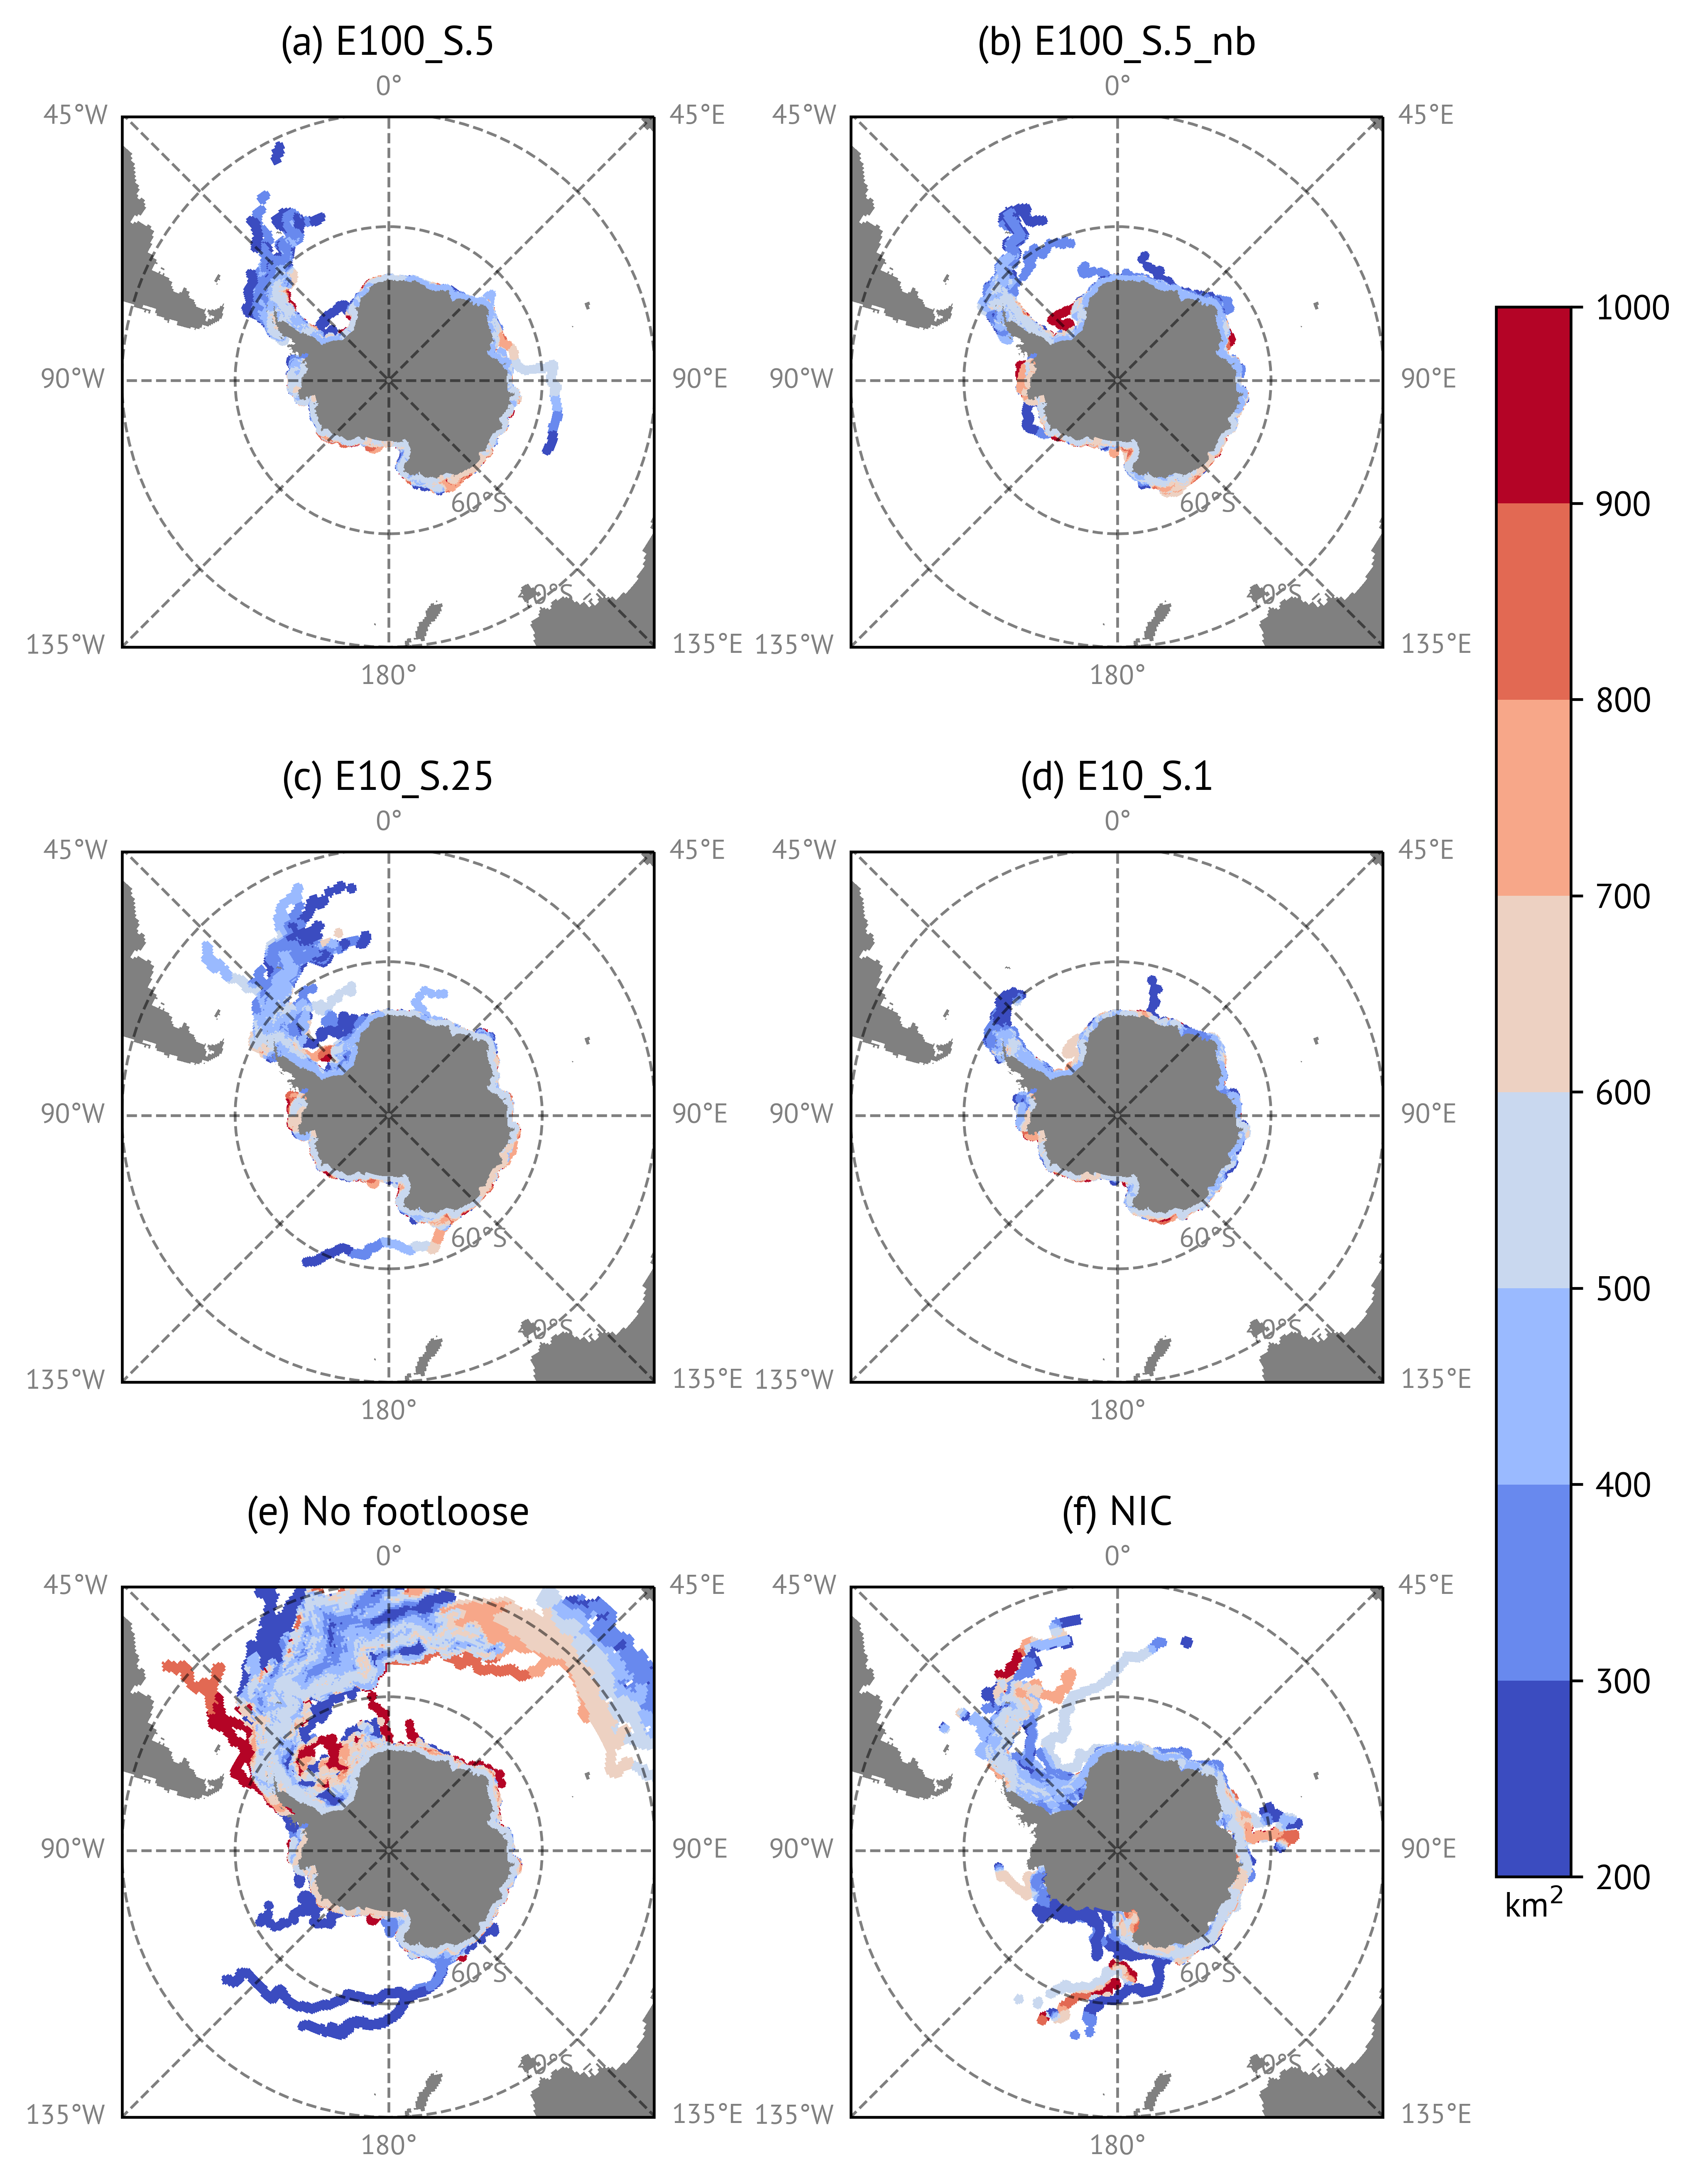

In [27]:
#PLOT 

#varm='u_bcount_modeled'; varn='u_bcount_nic'; label='percentage of icebergs within '+kernelstring2+' of grid point'
#varm='u_barea_modeled'; varn='u_barea_nic_small'; label='average area of icebergs (km^2) within '+kernelstring2+' of grid point'
#varm='u_barea_modeled_over100'; varn='u_barea_nic_small_over100'; label='average area of icebergs (km^2) within '+kernelstring2+' of grid point'
#varm='u_bage_modeled'; varn='u_bage_nic'; label='average age (years) of icebergs within '+kernelstring2+' of grid point'
#varm='u_barea_modeled_over100kms'; varn='u_barea_nic_small_over100kms'; label='average area (km^2) of icebergs (>100 km^2) within '+kernelstring2+' of grid point'
#varm='u_barea_modeled_over100nms'; varn='u_barea_nic_small_over100nms'; label='average area (km^2) of icebergs (>100 nm^2) within '+kernelstring2+' of grid point'
varm='u_barea_modeled_over200kms'; varn='u_barea_nic_small_over200kms'; label='average area (km^2) of icebergs (>200 km^2) within '+kernelstring2+' of grid point'


extent=[-180, 180, -90, -40]

subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=0.),facecolor='grey')

logplot = False
logplot2=False
override_bounds = False
minval=1e-5 #-32
minval2= 1e-32

if ((varm=='u_bcount_modeled') & (logplot==False)):
    scale=100.0
    Nc=8
    cb_label='%'
    pa=ga[varm].copy()*scale
    pb=gb[varm].copy()*scale
    pc=gc[varm].copy()*scale
    pd=gd[varm].copy()*scale
    pe=ge[varm].copy()*scale
    pf=gf[varn].copy()*scale
else:
    scale=1.0
    pa=ga[varm]
    pb=gb[varm]
    pc=gc[varm]
    pd=gd[varm]
    pe=ge[varm]
    pf=gf[varn]

if logplot:
    pa=np.log(pa.where(pa != 0)); pa=xr.where(ga[varm]==0,ga[varm],pa)
    pb=np.log(pb.where(pb != 0)); pb=xr.where(gb[varm]==0,gb[varm],pb)
    pc=np.log(pc.where(pc != 0)); pc=xr.where(gc[varm]==0,gc[varm],pc)
    pd=np.log(pd.where(pd != 0)); pd=xr.where(gd[varm]==0,gd[varm],pd)
    pe=np.log(pe.where(pe != 0)); pe=xr.where(ge[varm]==0,ge[varm],pe)
    pf=np.log(pf.where(pf != 0)); pf=xr.where(gf[varn]==0,gf[varn],pf)

if logplot2:
    #minval2=0
    pa=pa.where(pa != 0); pa=xr.where(ga[varm]==0,minval2,pa)
    pb=pb.where(pb != 0); pb=xr.where(gb[varm]==0,minval2,pb)
    pc=pc.where(pc != 0); pc=xr.where(gc[varm]==0,minval2,pc)
    pd=pd.where(pd != 0); pd=xr.where(gd[varm]==0,minval2,pd)
    pe=pe.where(pe != 0); pe=xr.where(ge[varm]==0,minval2,pe)
    pf=pf.where(pf != 0); pf=xr.where(gf[varn]==0,minval2,pf)
    
cmin_override = 5; cmax_override = 1000
minp=5; maxp=95 #min and max data percentiles, which specify range of data to plot
Nc=8

if varm=='u_barea_modeled':
    cb_label='km$^2$'
    override_bounds=True; cmin_override = 0; cmax_override = 1000
    Nc=8

if ((varm=='u_barea_modeled_over100') | (varm=='u_barea_modeled_over100kms')):
    cb_label='km$^2$'
    override_bounds=True; cmin_override = 100; cmax_override = 1000
    
if ((varm=='u_barea_modeled_over200kms') & (logplot==False)):
    cb_label='km$^2$'
    override_bounds=True; cmin_override = 200; cmax_override = 1000
    
if ((varm=='u_bcount_modeled') & (logplot2==True)):
    cb_label='%'
    override_bounds=True
    #cmin_override = 1e-1; cmax_override = 1e2
    cmin_override = 0.05; cmax_override = 50
    #cmin_override = 10**-0.5; cmax_override = 10**1.5
    Nc=9

if override_bounds:
    cmin2 = cmin_override
    cmax2 = cmax_override
else:
    if logplot:
        nper_pa= np.nanpercentile(pa.where(pa != 0),[minp,maxp])
        nper_pb= np.nanpercentile(pb.where(pb != 0),[minp,maxp])
        nper_pc= np.nanpercentile(pc.where(pc != 0),[minp,maxp])
        nper_pd= np.nanpercentile(pd.where(pd != 0),[minp,maxp]) 
        nper_pe= np.nanpercentile(pe.where(pe != 0),[minp,maxp])
        nper_pf= np.nanpercentile(pf.where(pf != 0),[minp,maxp])
    elif logplot2:
        nper_pa= np.nanpercentile(pa.where(pa > minval2),[minp,maxp])
        nper_pb= np.nanpercentile(pb.where(pb > minval2),[minp,maxp])
        nper_pc= np.nanpercentile(pc.where(pc > minval2),[minp,maxp])
        nper_pd= np.nanpercentile(pd.where(pd > minval2),[minp,maxp]) 
        nper_pe= np.nanpercentile(pe.where(pe > minval2),[minp,maxp])
        nper_pf= np.nanpercentile(pf.where(pf > minval2),[minp,maxp])
    else:
        nper_pa= np.nanpercentile(pa,[minp,maxp])
        nper_pb= np.nanpercentile(pb,[minp,maxp])
        nper_pc= np.nanpercentile(pc,[minp,maxp])  
        nper_pd= np.nanpercentile(pd,[minp,maxp]) 
        nper_pe= np.nanpercentile(pe,[minp,maxp])
        nper_pf= np.nanpercentile(pf,[minp,maxp])

    cmin2 = np.min([nper_pa,nper_pb,nper_pc,nper_pd,nper_pe,nper_pf])
    cmax2 = np.max([nper_pa,nper_pb,nper_pc,nper_pd,nper_pe,nper_pf])
    
print('min',cmin2,'max',cmax2)
         
plt.rcParams['figure.figsize']=[6,9]
fig, axes = plt.subplots(3,2, sharex=True, sharey=True, subplot_kw=subplot_kws,figsize=(6, 9))

if logplot:
    colors=np.array([(230,230,250),(124,162,221),(44,133,202),(15,192,127),(63,221,64),(189,221,13),(221,126,0),(221,0,0)])
    cmap = LinearSegmentedColormap.from_list('segmap', colors/255, N=10)
    cmap.set_over('w')
    label='log '+label
elif logplot2:
    colors=np.array([(230,230,250),(124,162,221),(44,133,202),(15,192,127),(63,221,64),(189,221,13),(221,126,0),(221,0,0)])
    cmap = LinearSegmentedColormap.from_list('segmap', colors/255, N=Nc)
    #cmap.set_over('w')
    #label='log '+label
else:
    #cmap = copy.copy(plt.cm.get_cmap("gnuplot_r"))
    cmap = copy.copy(plt.cm.get_cmap("coolwarm",Nc))
    #cmap=plt.get_cmap('gnuplot_r')
#     cmap.set_under('w')
#     if cmin2<1e-32:
#         cmin2=1e-32
    cmap.set_under('w')
    if cmin2<minval*scale:
        cmin2=minval*scale

if cmin2<=minval*scale:
    cmin2=minval*scale
cmap.set_under('w')

if logplot2:    
    m_pa = pa.plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_pb = pb.plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_pc = pc.plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_pd = pd.plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_pe = pe.plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_pf = pf.plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
else:
    m_pa = pa.plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
    m_pb = pb.plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
    m_pc = pc.plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
    m_pd = pd.plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
    m_pe = pe.plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
    m_pf = pf.plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)

g1=plotformatting(axes[0,0])
g2=plotformatting(axes[0,1])
g3=plotformatting(axes[1,0])
g4=plotformatting(axes[1,1])
g5=plotformatting(axes[2,0])
g6=plotformatting(axes[2,1])

# m_pa.axes.set_extent(extent,ccrs.PlateCarree()); g1=m_pa.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g1=fixlatlabel(g1,plt)
# m_pb.axes.set_extent(extent,ccrs.PlateCarree()); g2=m_pb.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g2=fixlatlabel(g2,plt)
# m_pc.axes.set_extent(extent,ccrs.PlateCarree()); g3=m_pc.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g3=fixlatlabel(g3,plt)
# m_pd.axes.set_extent(extent,ccrs.PlateCarree()); g4=m_pd.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g4=fixlatlabel(g4,plt)
# m_pe.axes.set_extent(extent,ccrs.PlateCarree()); g5=m_pe.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g5=fixlatlabel(g5,plt)
# m_pf.axes.set_extent(extent,ccrs.PlateCarree()); g6=m_pf.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True); g6=fixlatlabel(g6,plt)

titlesize=12; titlepad=12
m_pa.axes.set_title('(a) '+rname_a, size=titlesize)#, pad=titlepad)
m_pb.axes.set_title('(b) '+rname_b, size=titlesize)#, pad=titlepad)
m_pc.axes.set_title('(c) '+rname_c, size=titlesize)#, pad=titlepad)
m_pd.axes.set_title('(d) '+rname_d, size=titlesize)#, pad=titlepad)
m_pe.axes.set_title('(e) '+rname_e, size=titlesize)#, pad=titlepad)
m_pf.axes.set_title('(f) '+rname_f, size=titlesize)#, pad=titlepad)


#axes[0,1].set_visible(False); axes[1,0].set_visible(False); axes[1,1].set_visible(False); axes[2,0].set_visible(False); axes[2,1].set_visible(False)
#fig.subplots_adjust(hspace=0,wspace=0.5)
#plt.tight_layout()
#fig.colorbar(m_pa, ax=axes.ravel().tolist(), shrink=0.75, location='right', label=label)

plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7]) #right, up, width, height
b=fig.colorbar(m_pe, cax=cbar_ax) 
b.ax.set_xlabel(cb_label)